# Medical-image project

# Read_Data

In [ ]:
from skimage import data, io, img_as_ubyte, img_as_float
from skimage.util import invert
from scipy.ndimage import convolve, filters
from skimage import exposure
from skimage.filters.rank import median, gradient
from skimage.morphology import disk
from skimage.exposure import equalize_hist
from scipy import ndimage
from skimage.filters import laplace, sobel, roberts
from skimage.color import rgb2gray, gray2rgb, rgb2hsv
from skimage.exposure import rescale_intensity
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.filters import threshold_otsu
import cv2
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# Read the image
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image

# Step 1: Read the image files from the respective folders
Normal_folder = '/content/drive/MyDrive/project-Medical_Image/Normal cases'
Benign_folder = '/content/drive/MyDrive/project-Medical_Image/Bengin cases'
Malignant_folder = '/content/drive/MyDrive/project-Medical_Image/Malignant cases'

Normal_files = os.listdir(Normal_folder)
Benign_files = os.listdir(Benign_folder)
Malignant_files = os.listdir(Malignant_folder)

#**Pre**-**Processing**
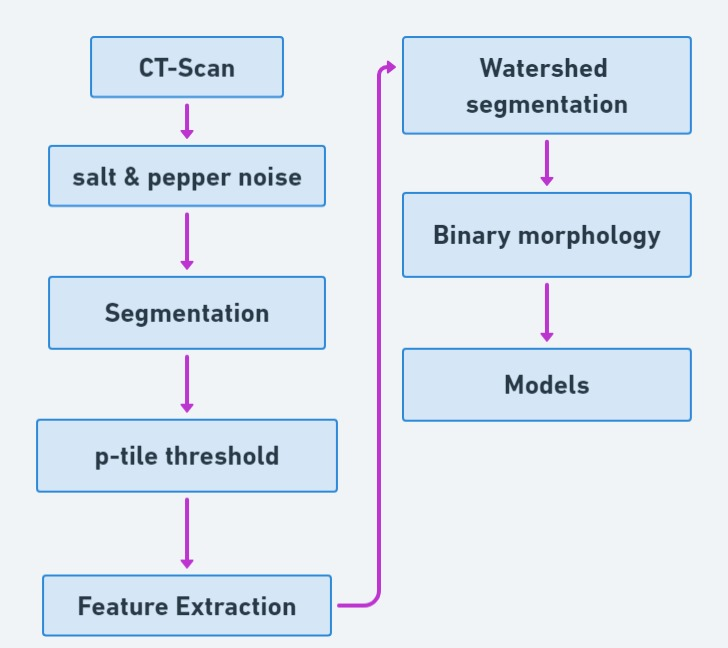

#CT-Scan


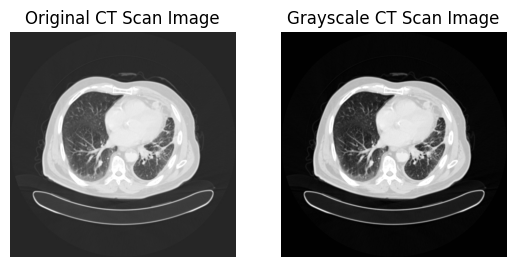

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def display_original_and_grayscale_ct_scan(image_path):
    # Read the CT scan image
    ct_scan = cv2.imread(image_path)

    # Convert the CT scan image to grayscale
    gray_ct_scan = cv2.cvtColor(ct_scan, cv2.COLOR_BGR2GRAY)

    # Convert the CT scan image to RGB for displaying the original image
    ct_scan_rgb = cv2.cvtColor(ct_scan, cv2.COLOR_BGR2RGB)

    # Display the original CT scan image
    plt.subplot(1, 2, 1)
    plt.imshow(ct_scan_rgb)
    plt.title('Original CT Scan Image')
    plt.axis('off')

    # Display the grayscale CT scan image
    plt.subplot(1, 2, 2)
    plt.imshow(gray_ct_scan, cmap='gray')
    plt.title('Grayscale CT Scan Image')
    plt.axis('off')

    plt.show()

# Path to the CT scan image
image_path = '/content/drive/MyDrive/project-Medical_Image/Malignant cases/Malignant case (1).jpg'

# Display the original and grayscale CT scan images
display_original_and_grayscale_ct_scan(image_path)


# Add salt and pepper noise
and remove it with median

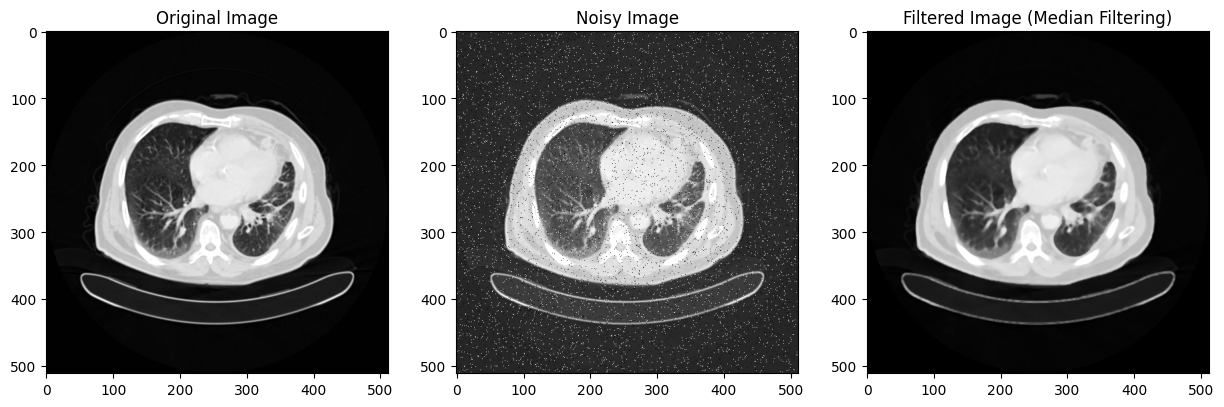

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image_path = '/content/drive/MyDrive/project-Medical_Image/Malignant cases/Malignant case (1).jpg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    total_pixels = image.size

    num_salt = int(salt_prob * total_pixels)
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    num_pepper = int(pepper_prob * total_pixels)
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

salt_prob = 0.02
pepper_prob = 0.02
noisy_image = add_salt_and_pepper_noise(original_image, salt_prob, pepper_prob)

filtered_image = cv2.medianBlur(noisy_image, 5)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(original_image, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(noisy_image, cmap='gray')
axs[1].set_title('Noisy Image')

axs[2].imshow(filtered_image, cmap='gray')
axs[2].set_title('Filtered Image (Median Filtering)')

plt.show()


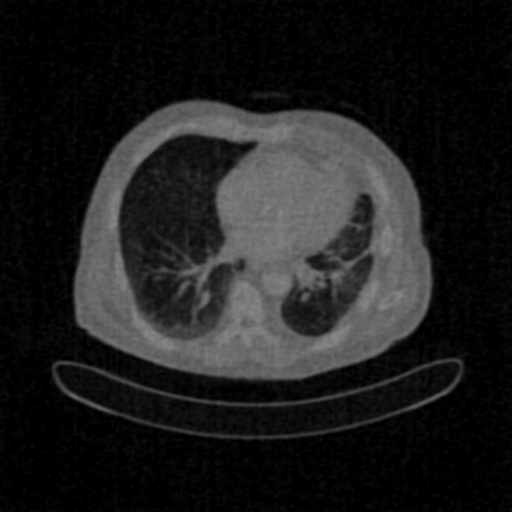

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def wiener_filter(input_image, noise_image, desired_output_image):
    # Resize images to a common size
    common_shape = input_image.shape[:2]
    noise_image = cv2.resize(noise_image, common_shape[::-1])
    desired_output_image = cv2.resize(desired_output_image, common_shape[::-1])

    # Convert the images to grayscale if necessary
    if len(input_image.shape) > 2:
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    if len(noise_image.shape) > 2:
        noise_image = cv2.cvtColor(noise_image, cv2.COLOR_BGR2GRAY)
    if len(desired_output_image.shape) > 2:
        desired_output_image = cv2.cvtColor(desired_output_image, cv2.COLOR_BGR2GRAY)

    # Compute the power spectral densities
    input_psd = np.abs(np.fft.fft2(input_image)) ** 2
    noise_psd = np.abs(np.fft.fft2(noise_image)) ** 2
    desired_psd = np.abs(np.fft.fft2(desired_output_image)) ** 2

    # Compute the cross-power spectral density
    cross_psd = np.conj(np.fft.fft2(noise_image)) * np.fft.fft2(desired_output_image)

    # Calculate the Wiener filter transfer function
    wiener_filter_tf = cross_psd / (input_psd + noise_psd)

    # Apply the filter in the frequency domain
    filtered_image = np.fft.ifft2(wiener_filter_tf * np.fft.fft2(input_image)).real

    return filtered_image

# Example usage
input_image = cv2.imread('/content/drive/MyDrive/project-Medical_Image/Malignant cases/Malignant case (1).jpg')  # Load input image
noise_image = cv2.imread('/content/drive/MyDrive/project-Medical_Image/Noisy-image.png')  # Load noise image
desired_output_image = cv2.imread('/content/drive/MyDrive/project-Medical_Image/Grayscale CT Scan.png')  # Load desired output image

filtered_image = wiener_filter(input_image, noise_image, desired_output_image)

# Display the filtered image
cv2_imshow(filtered_image)


# **Segmentations:**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


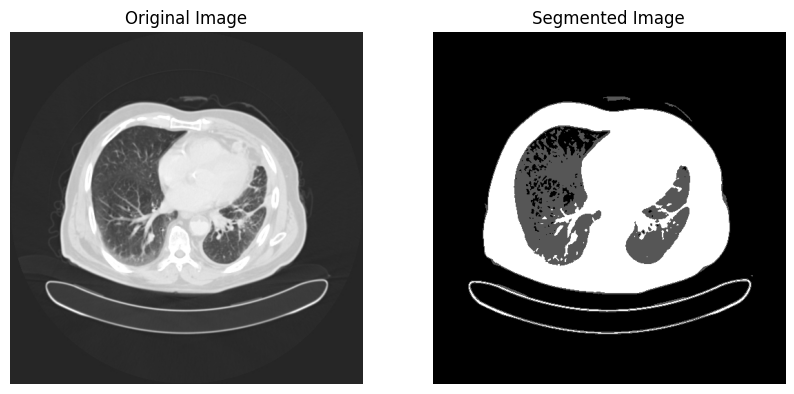

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the lung cancer image
image = cv2.imread('/content/drive/MyDrive/project-Medical_Image/Malignant cases/Malignant case (1).jpg')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Reshape the image to a 1D array of pixels
pixels = gray_image.reshape((-1, 1))

# Define the number of clusters (k)
k = 3

# Apply k-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(pixels)

# Get the cluster centroids and labels
centers = np.uint8(kmeans.cluster_centers_)
labels = kmeans.labels_

# Assign each pixel to its cluster centroid
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(gray_image.shape)

# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()


Approximation (cA): Mean = 174.23916625976562 Std Deviation = 143.5613485012905
Horizontal detail (cH): Mean = -0.005081176757812497 Std Deviation = 9.170654055873124
Vertical detail (cV): Mean = 0.00036621093750002147 Std Deviation = 6.696129470843856
Diagonal detail (cD): Mean = -0.0009918212890625126 Std Deviation = 1.7843138377985195


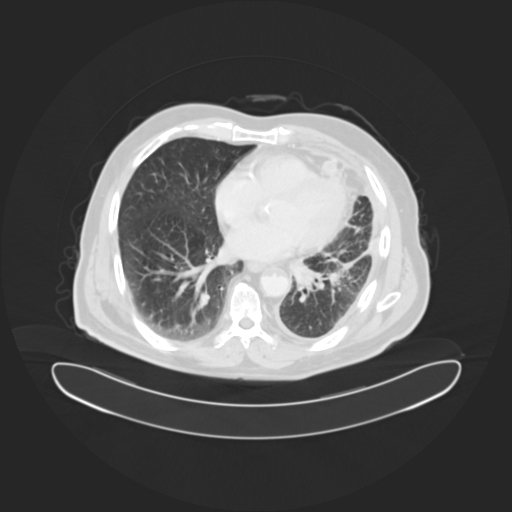

In [ ]:
import cv2
import numpy as np
import pywt
from google.colab.patches import cv2_imshow

# Load lung cancer image
image = cv2.imread('/content/drive/MyDrive/project-Medical_Image/Malignant cases/Malignant case (1).jpg')

# Preprocessing (e.g., convert to grayscale)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# DWT Decomposition
coeffs = pywt.dwt2(gray_image, 'haar')

# Feature Extraction
# Example: Compute mean and standard deviation of wavelet coefficients
cA, (cH, cV, cD) = coeffs
mean_cA = np.mean(cA)
std_cA = np.std(cA)
mean_cH = np.mean(cH)
std_cH = np.std(cH)
mean_cV = np.mean(cV)
std_cV = np.std(cV)
mean_cD = np.mean(cD)
std_cD = np.std(cD)

# Example: Print extracted features
print("Approximation (cA): Mean =", mean_cA, "Std Deviation =", std_cA)
print("Horizontal detail (cH): Mean =", mean_cH, "Std Deviation =", std_cH)
print("Vertical detail (cV): Mean =", mean_cV, "Std Deviation =", std_cV)
print("Diagonal detail (cD): Mean =", mean_cD, "Std Deviation =", std_cD)

# ROI Detection and Extraction
# Example: Thresholding based on feature values

# Visualization
cv2_imshow(image)
# Display other images or visualizations as needed


### p-tile threshold:
with three diff cases

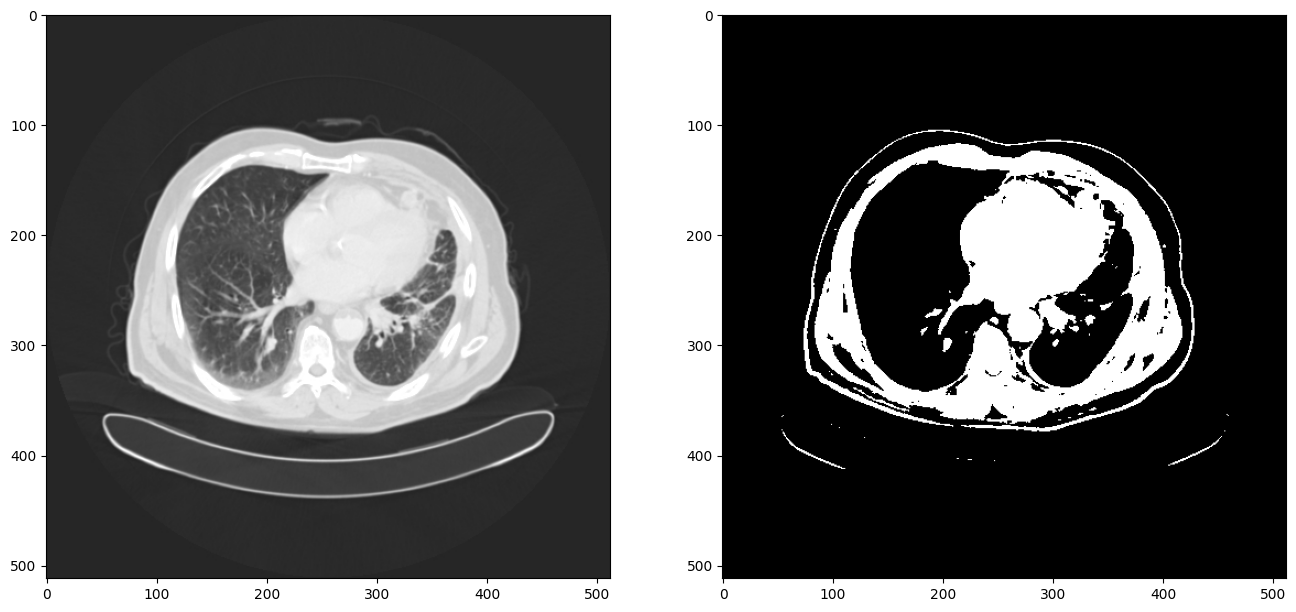

In [ ]:
image = cv2.imread('/content/drive/MyDrive/project-Medical_Image/Malignant cases/Malignant case (1).jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ptile = 85
threshold = np.percentile(gray, ptile)
binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('thresholded_image_M.jpg', binary)
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
ax1.imshow( image ,'gray')
ax2.imshow( binary,'gray')
plt.show()

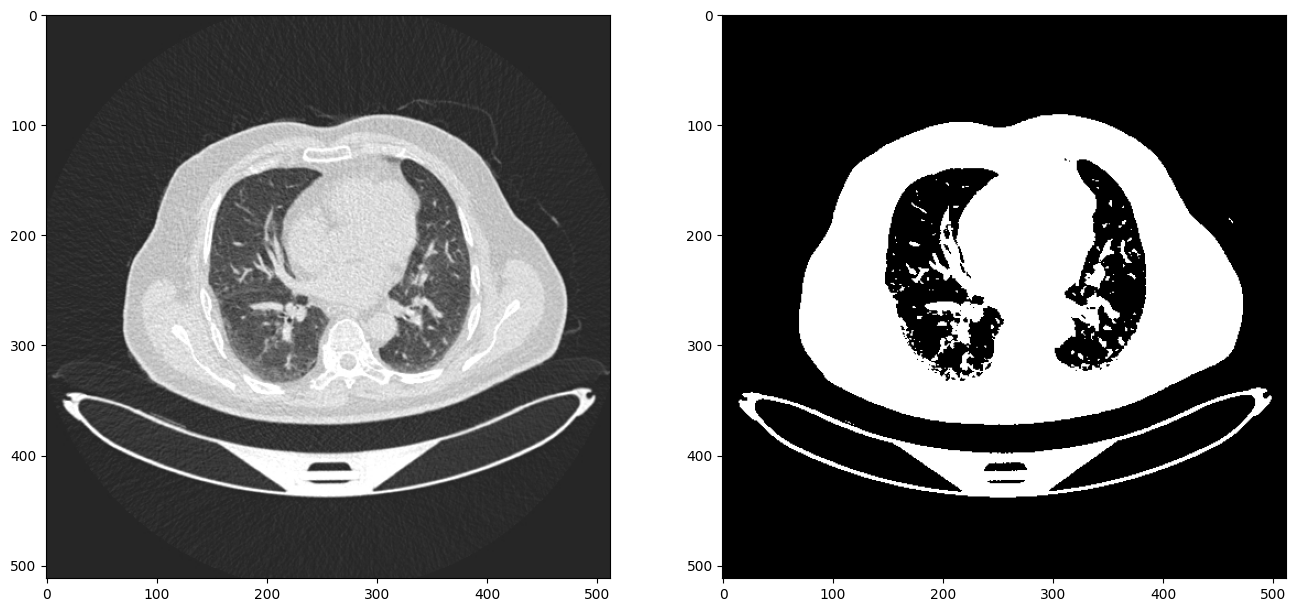

In [ ]:
image = cv2.imread('/content/drive/MyDrive/project-Medical_Image/Bengin cases/Bengin case (1).jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ptile = 70
threshold = np.percentile(gray, ptile)
binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('thresholded_image_B.jpg', binary)
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
ax1.imshow( image ,'gray')
ax2.imshow( binary,'gray')
plt.show()


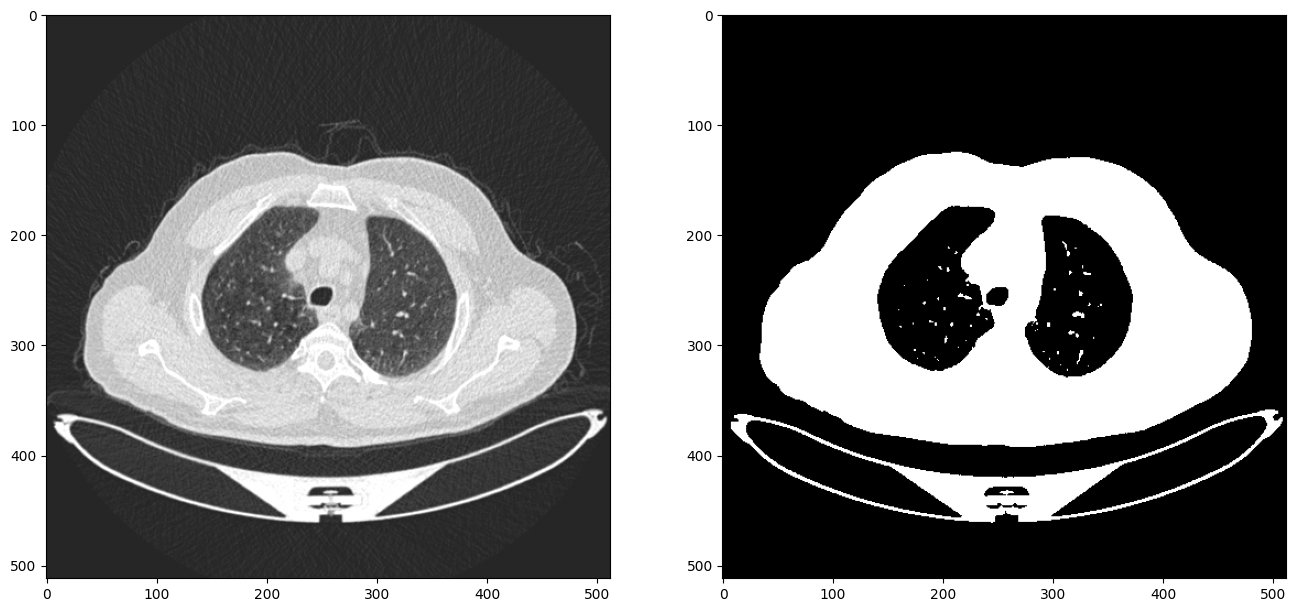

In [ ]:
image = cv2.imread('/content/drive/MyDrive/project-Medical_Image/Normal cases/Normal case (1).jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ptile = 70
threshold = np.percentile(gray, ptile)
binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('thresholded_image_N.jpg', binary)
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
ax1.imshow( image ,'gray')
ax2.imshow( binary,'gray')
plt.show()

#Feature Ecxtraction

In [ ]:
import numpy as np
from skimage.feature import greycomatrix, greycoprops
import cv2

# Load the lung cancer image
image = cv2.imread('/content/drive/MyDrive/project-Medical_Image/Malignant cases/Malignant case (1).jpg', cv2.IMREAD_GRAYSCALE)

# Define parameters for GLCM computation
distances = [1, 2, 3]  # Pixel pair distances
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Pixel pair orientations

# Compute the GLCM
glcm = greycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

# Extract GLCM properties (features)
contrast = greycoprops(glcm, 'contrast')
dissimilarity = greycoprops(glcm, 'dissimilarity')
homogeneity = greycoprops(glcm, 'homogeneity')
energy = greycoprops(glcm, 'energy')
correlation = greycoprops(glcm, 'correlation')

# Print the extracted features
print("Contrast:", contrast)
print("Dissimilarity:", dissimilarity)
print("Homogeneity:", homogeneity)
print("Energy:", energy)
print("Correlation:", correlation)


Contrast: [[ 48.2500344  134.23279246  86.63335525 123.35539846]
 [164.67944623 134.23279246 281.57457108 123.35539846]
 [306.53484544 407.77605152 482.65324165 373.64024221]]
Dissimilarity: [[2.38280103 3.94540845 3.01927899 3.74880994]
 [4.35466069 3.94540845 5.51348805 3.74880994]
 [5.95916089 6.951807   7.44462181 6.59316801]]
Homogeneity: [[0.63871977 0.58500244 0.62959296 0.58967801]
 [0.56414302 0.58500244 0.55452537 0.58967801]
 [0.53880324 0.52610998 0.52563414 0.53047652]]
Energy: [[0.24674134 0.24057494 0.24677582 0.24084775]
 [0.23834565 0.24057494 0.23791108 0.24084775]
 [0.2346792  0.23270578 0.23382779 0.23311997]]
Correlation: [[0.99535245 0.98708387 0.99165529 0.98813051]
 [0.98415445 0.98708387 0.97290678 0.98813051]
 [0.97053634 0.96084551 0.95360823 0.96412322]]


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Combine all features into a single array
all_features = np.hstack((contrast.flatten(), dissimilarity.flatten(), homogeneity.flatten(), energy.flatten(), correlation.flatten()))

# Initialize VarianceThreshold selector
selector = VarianceThreshold(threshold=0.01)  # You can adjust the threshold as needed

# Fit selector to data
selector.fit(all_features.reshape(-1, 1))

# Get indices of selected features
selected_indices = np.where(selector.variances_ > 0.01)[0]

# Select features based on indices
selected_features = all_features[selected_indices]

# Reshape selected features
selected_features = selected_features.reshape(1, -1)

# Print selected features
print("Selected Features:", selected_features)

# Print indices of selected features
print("Indices of Selected Features:", selected_indices)


Selected Features: [[48.2500344]]
Indices of Selected Features: [0]


# Watershed segmentation

### **Using image after apply p-tile thresholding(Image Malignant):**

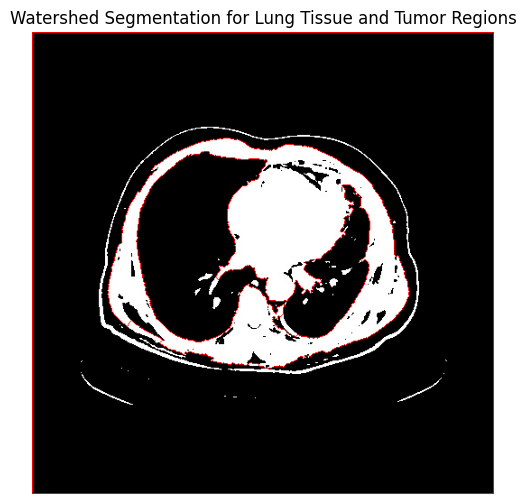

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the lung CT scan image
input_image_path = ('/content/thresholded_image_M.jpg')
lung_image = cv2.imread(input_image_path)

# Convert the lung image to grayscale
gray_lung = cv2.cvtColor(lung_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray_lung, (5, 5), 0)

# Apply morphological operations (e.g., erosion and dilation)
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(blurred, kernel, iterations=1)
dilation = cv2.dilate(erosion, kernel, iterations=1)

# Perform thresholding to segment potential tumor regions
ret, thresh = cv2.threshold(dilation, 127, 255, cv2.THRESH_BINARY)

# Perform morphological operations on the thresholded image
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

# Apply distance transform
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find the unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling for watershed algorithm
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed segmentation
markers = cv2.watershed(lung_image, markers)
lung_image[markers == -1] = [0, 0, 255]  # Color the boundary with red (tumor regions)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(lung_image, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation for Lung Tissue and Tumor Regions')
plt.axis('off')
plt.show()

### **Using original image from dataset(Image Malignant):**

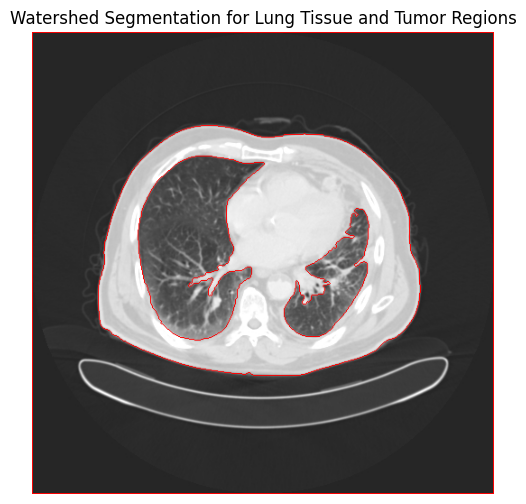

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the lung CT scan image
input_image_path = ('/content/drive/MyDrive/project-Medical_Image/Malignant cases/Malignant case (1).jpg')
lung_image = cv2.imread(input_image_path)

# Convert the lung image to grayscale
gray_lung = cv2.cvtColor(lung_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray_lung, (5, 5), 0)

# Apply morphological operations (e.g., erosion and dilation)
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(blurred, kernel, iterations=1)
dilation = cv2.dilate(erosion, kernel, iterations=1)

# Perform thresholding to segment potential tumor regions
ret, thresh = cv2.threshold(dilation, 127, 255, cv2.THRESH_BINARY)

# Perform morphological operations on the thresholded image
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

# Apply distance transform
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find the unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling for watershed algorithm
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed segmentation
markers = cv2.watershed(lung_image, markers)
lung_image[markers == -1] = [0, 0, 255]  # Color the boundary with red (tumor regions)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(lung_image, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation for Lung Tissue and Tumor Regions')
plt.axis('off')
plt.show()

### **Using image after apply p-tile thresholding(Bengin image):**

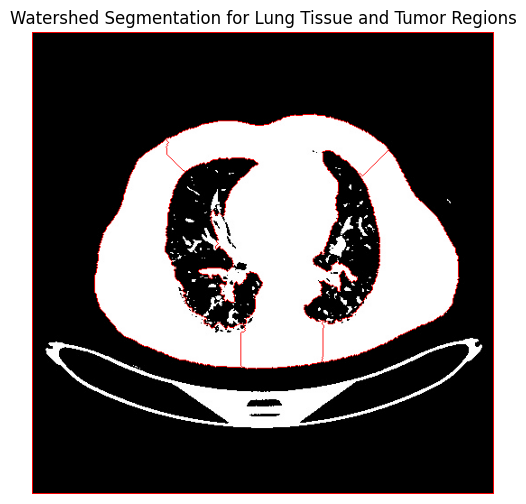

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the lung CT scan image
input_image_path = ('/content/thresholded_image_B.jpg')
lung_image = cv2.imread(input_image_path)

# Convert the lung image to grayscale
gray_lung = cv2.cvtColor(lung_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray_lung, (5, 5), 0)

# Apply morphological operations (e.g., erosion and dilation)
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(blurred, kernel, iterations=1)
dilation = cv2.dilate(erosion, kernel, iterations=1)

# Perform thresholding to segment potential tumor regions
ret, thresh = cv2.threshold(dilation, 127, 255, cv2.THRESH_BINARY)

# Perform morphological operations on the thresholded image
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

# Apply distance transform
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find the unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling for watershed algorithm
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed segmentation
markers = cv2.watershed(lung_image, markers)
lung_image[markers == -1] = [0, 0, 255]  # Color the boundary with red (tumor regions)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(lung_image, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation for Lung Tissue and Tumor Regions')
plt.axis('off')
plt.show()

### **Using original image(Bengin image):**

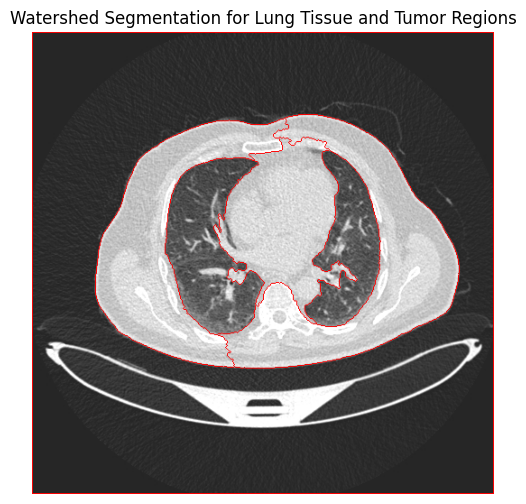

True

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the lung CT scan image
input_image_path = ('/content/drive/MyDrive/project-Medical_Image/Bengin cases/Bengin case (1).jpg')
lung_image = cv2.imread(input_image_path)

# Convert the lung image to grayscale
gray_lung = cv2.cvtColor(lung_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray_lung, (5, 5), 0)

# Apply morphological operations (e.g., erosion and dilation)
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(blurred, kernel, iterations=1)
dilation = cv2.dilate(erosion, kernel, iterations=1)

# Perform thresholding to segment potential tumor regions
ret, thresh = cv2.threshold(dilation, 127, 255, cv2.THRESH_BINARY)

# Perform morphological operations on the thresholded image
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

# Apply distance transform
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find the unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling for watershed algorithm
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed segmentation
markers = cv2.watershed(lung_image, markers)
lung_image[markers == -1] = [0, 0, 255]  # Color the boundary with red (tumor regions)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(lung_image, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation for Lung Tissue and Tumor Regions')
plt.axis('off')
plt.show()

# Save the output image
output_path = '/content/drive/MyDrive/segmented_lung_with_tumor.jpg'
cv2.imwrite(output_path, lung_image)

### **Using image after apply p-tile thresholding(Normal image):**

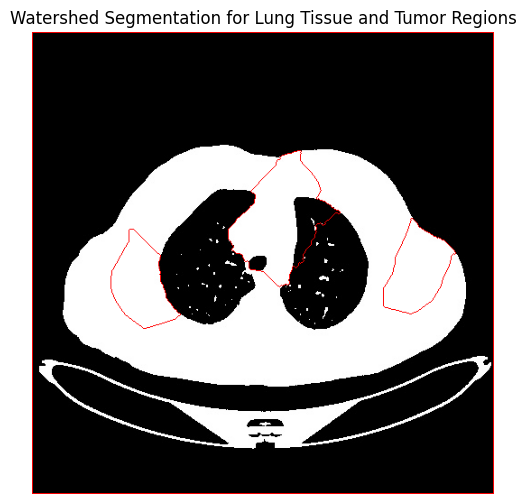

In [ ]:
# Load the lung CT scan image
input_image_path = ('/content/thresholded_image_N.jpg')
lung_image = cv2.imread(input_image_path)

# Marker labelling for watershed algorithm
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed segmentation
markers = cv2.watershed(lung_image, markers)
lung_image[markers == -1] = [0, 0, 255]  # Color the boundary with red (tumor regions)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(lung_image, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation for Lung Tissue and Tumor Regions')
plt.axis('off')
plt.show()

### **using original image(normal image):**

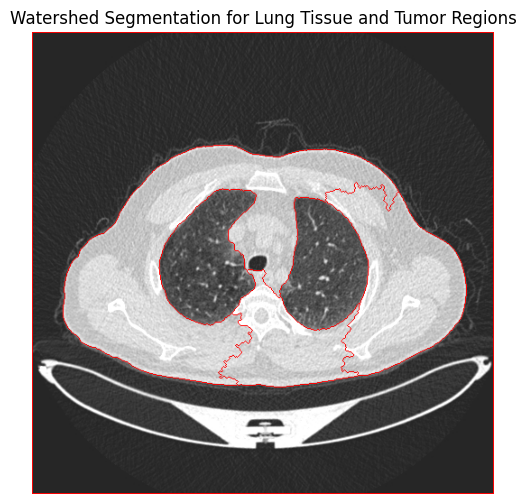

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the lung CT scan image
input_image_path = ('/content/drive/MyDrive/Data-set-20231226T185807Z-001/Data-set/Normal cases/Normal case (1).jpg')
lung_image = cv2.imread(input_image_path)

# Convert the lung image to grayscale
gray_lung = cv2.cvtColor(lung_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray_lung, (5, 5), 0)

# Apply morphological operations (e.g., erosion and dilation)
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(blurred, kernel, iterations=1)
dilation = cv2.dilate(erosion, kernel, iterations=1)

# Perform thresholding to segment potential tumor regions
ret, thresh = cv2.threshold(dilation, 127, 255, cv2.THRESH_BINARY)

# Perform morphological operations on the thresholded image
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

# Apply distance transform
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find the unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling for watershed algorithm
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed segmentation
markers = cv2.watershed(lung_image, markers)
lung_image[markers == -1] = [0, 0, 255]  # Color the boundary with red (tumor regions)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(lung_image, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation for Lung Tissue and Tumor Regions')
plt.axis('off')
plt.show()

# Binary morphology
To detect the erosion,dilation,oppening and closing

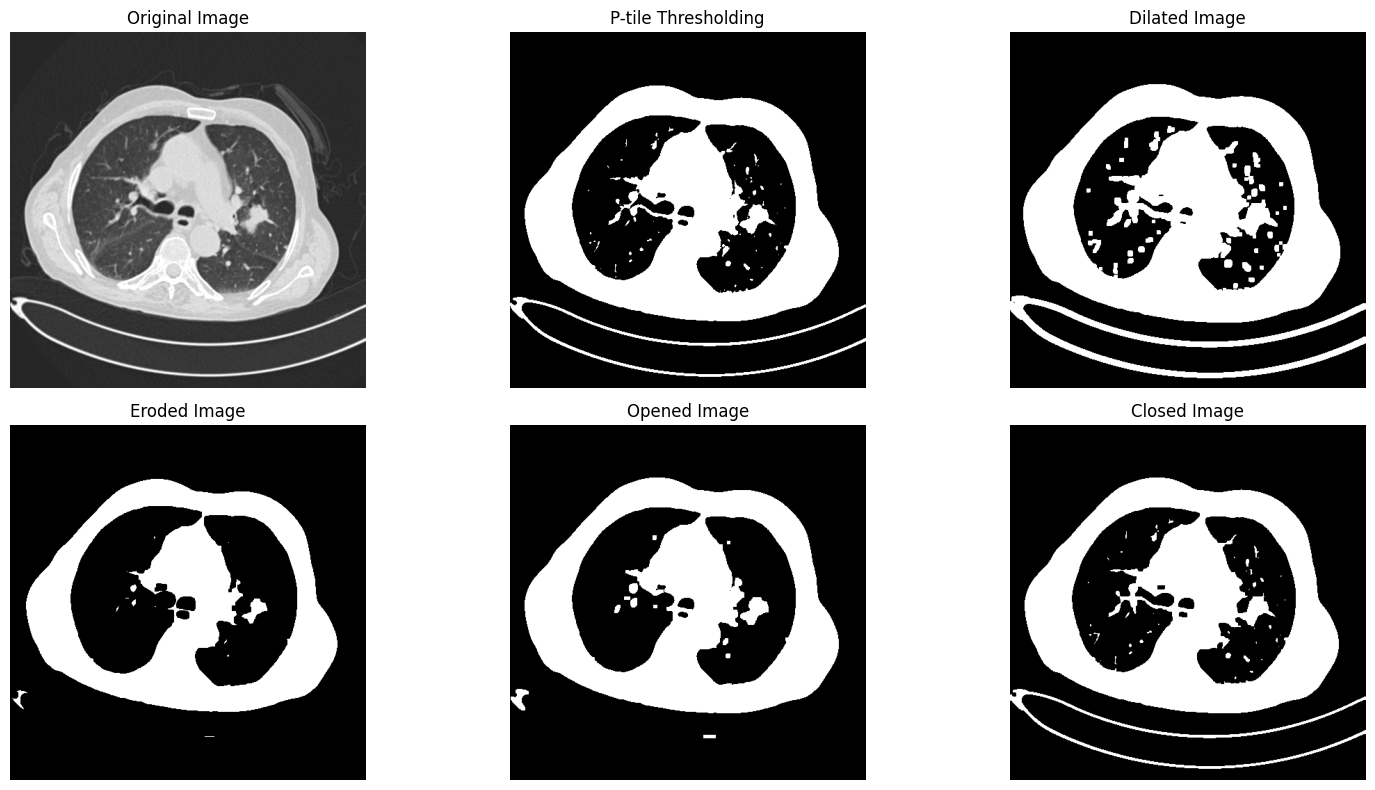

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('/content/drive/MyDrive/Data-set-20231226T185807Z-001/Data-set/Malignant cases/Malignant case (2).jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply P-tile thresholding
ptile = 70
threshold = np.percentile(gray, ptile)
binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]

# Apply morphological operations (dilation, erosion, opening, closing)
kernel = np.ones((5, 5), np.uint8)  # Example: 5x5 square kernel
dilated_image = cv2.dilate(binary, kernel, iterations=1)
eroded_image = cv2.erode(binary, kernel, iterations=1)
opened_image = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
closed_image = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Plotting the original and processed images
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(binary, cmap='gray')
axes[0, 1].set_title('P-tile Thresholding')
axes[0, 1].axis('off')

axes[0, 2].imshow(dilated_image, cmap='gray')
axes[0, 2].set_title('Dilated Image')
axes[0, 2].axis('off')

axes[1, 0].imshow(eroded_image, cmap='gray')
axes[1, 0].set_title('Eroded Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(opened_image, cmap='gray')
axes[1, 1].set_title('Opened Image')
axes[1, 1].axis('off')

axes[1, 2].imshow(closed_image, cmap='gray')
axes[1, 2].set_title('Closed Image')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


### **Using image from watershed segmentation:**

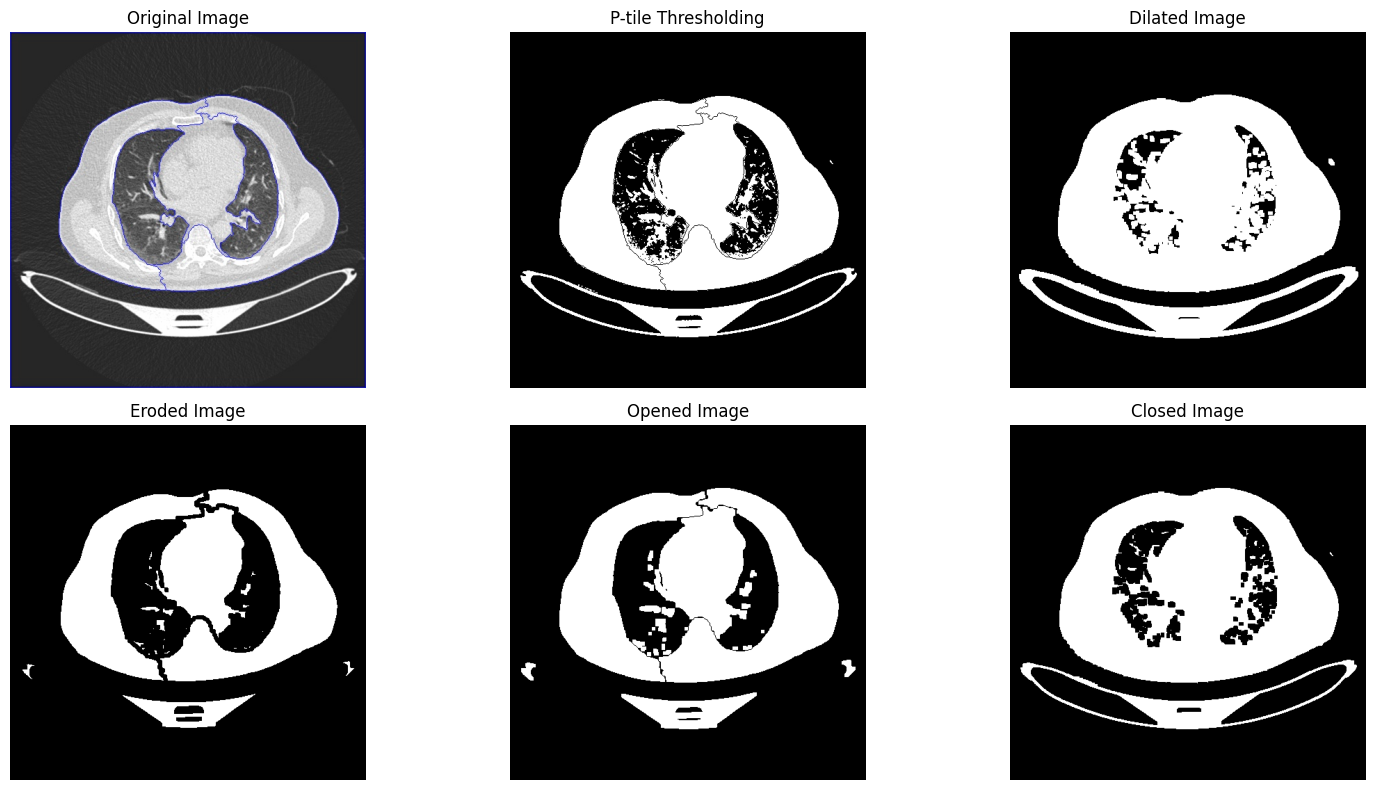

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('/content/drive/MyDrive/segmented_lung_with_tumor.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply P-tile thresholding
ptile = 70
threshold = np.percentile(gray, ptile)
binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]

# Apply morphological operations (dilation, erosion, opening, closing)
kernel = np.ones((5, 5), np.uint8)  # Example: 5x5 square kernel
dilated_image = cv2.dilate(binary, kernel, iterations=1)
eroded_image = cv2.erode(binary, kernel, iterations=1)
opened_image = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
closed_image = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Plotting the original and processed images
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(binary, cmap='gray')
axes[0, 1].set_title('P-tile Thresholding')
axes[0, 1].axis('off')

axes[0, 2].imshow(dilated_image, cmap='gray')
axes[0, 2].set_title('Dilated Image')
axes[0, 2].axis('off')

axes[1, 0].imshow(eroded_image, cmap='gray')
axes[1, 0].set_title('Eroded Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(opened_image, cmap='gray')
axes[1, 1].set_title('Opened Image')
axes[1, 1].axis('off')

axes[1, 2].imshow(closed_image, cmap='gray')
axes[1, 2].set_title('Closed Image')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


# Output image with cancer depicted area
using segmentation method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


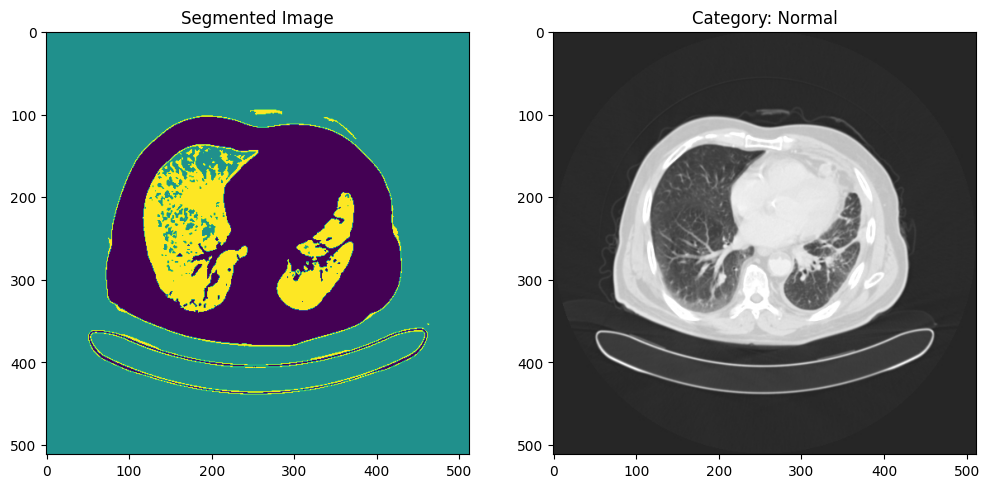

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


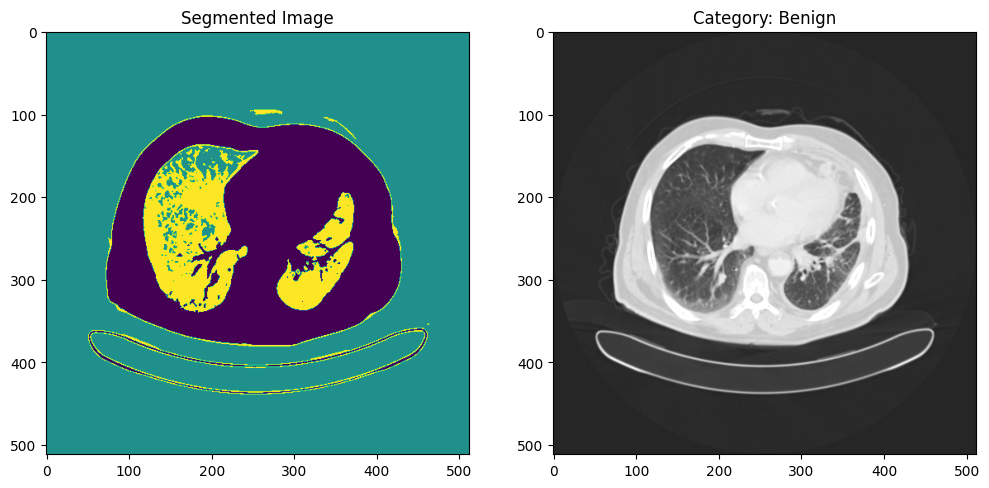

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


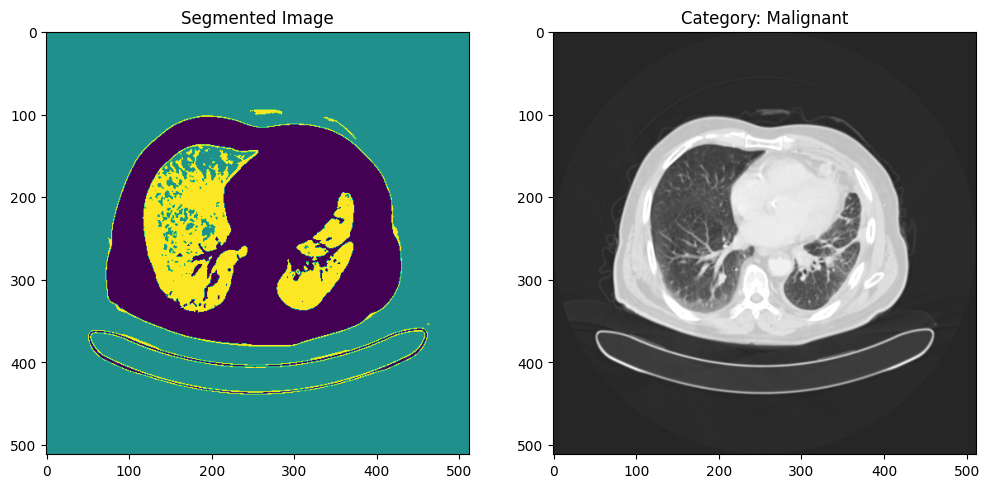

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image

def segment_image(image_path, num_clusters):
    image = np.array(Image.open(image_path))

    pixels = image.reshape((-1, 3))

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)

    segmented_image = labels.reshape(image.shape[:2])

    return image, segmented_image
categories = ['Normal', 'Benign', 'Malignant']

num_clusters = 3

for category in categories:
    category_path = os.path.join('/content/drive/MyDrive/project-D_Image/Data-set', category)

    if os.path.isdir(category_path):
        image_files = [f for f in os.listdir(category_path) if f.endswith('.jpg')]

        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)

            original_image, segmented_image = segment_image(image_path, num_clusters)

            fig, axs = plt.subplots(1, 2, figsize=(12, 12))

            axs[0].imshow(segmented_image, cmap='viridis')
            axs[0].set_title("Segmented Image")

            axs[1].imshow(original_image)
            axs[1].set_title(f'Category: {category.capitalize()}')

            plt.show()
    else:
        original_image, segmented_image = segment_image(image_path, num_clusters)

        fig, axs = plt.subplots(1, 2, figsize=(12, 12))

        axs[0].imshow(segmented_image, cmap='viridis')
        axs[0].set_title("Segmented Image")
        axs[1].imshow(original_image)
        axs[1].set_title(f'Category: {category.capitalize()}')

        plt.show()


#SVM Model

In [ ]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

data_folder = '/content/drive/MyDrive/project-Medical_Image'
images, labels = load_images_from_folder(data_folder)


In [ ]:
from skimage.feature import hog
from skimage import exposure

def extract_features(images):
    features = []
    for img in images:
        img = cv2.resize(img, (64, 128))  # Resize image
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False, transform_sqrt=True)
        features.append(hog_features)
    return np.array(features)

X = extract_features(images)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1.0, probability=True)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9861111111111112
                 precision    recall  f1-score   support

   Bengin cases       0.97      1.00      0.99        35
Malignant cases       1.00      0.95      0.97        20
   Normal cases       1.00      1.00      1.00        17

       accuracy                           0.99        72
      macro avg       0.99      0.98      0.99        72
   weighted avg       0.99      0.99      0.99        72



In [ ]:
def predict_single_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 128))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False, transform_sqrt=True)
    hog_features = np.array([hog_features])
    prediction = svm_model.predict(hog_features)
    return prediction[0]

new_image_path = '/content/drive/MyDrive/project-Medical_Image/Normal cases/Normal case (10).jpg'
predicted_class = predict_single_image(new_image_path)
print("Predicted Class:", predicted_class)

Predicted Class: Normal cases


# CNN Model


In [ ]:
pip install keras

In [ ]:
pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Step 1: Data Preprocessing
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

data_folder = '/content/drive/MyDrive/project-Medical_Image'
images, labels = load_images_from_folder(data_folder)


In [ ]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = cv2.resize(img, (64, 64))  # Resize image
        img = img / 255.0  # Normalize pixel values to range [0, 1]
        processed_images.append(img)
    return np.array(processed_images)

X = preprocess_images(images)

In [ ]:
# Convert labels to one-hot encoded vectors
label_dict = {'Normal cases': 0, 'Bengin cases': 1, 'Malignant cases': 2}
y = np.array([label_dict[label] for label in labels])
y = tf.keras.utils.to_categorical(y, num_classes=3)

In [ ]:
# Step 2: Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Step 3: Building the CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step 4: Training the CNN Model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
5/5 [==============================] - 7s 207ms/step - loss: 1.0818 - accuracy: 0.4238 - val_loss: 0.9537 - val_accuracy: 0.5882
Epoch 2/10
5/5 [==============================] - 0s 20ms/step - loss: 0.9296 - accuracy: 0.5430 - val_loss: 0.9786 - val_accuracy: 0.5882
Epoch 3/10
5/5 [==============================] - 0s 20ms/step - loss: 0.8231 - accuracy: 0.6424 - val_loss: 0.9961 - val_accuracy: 0.5294
Epoch 4/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6383 - accuracy: 0.7483 - val_loss: 0.7131 - val_accuracy: 0.7059
Epoch 5/10
5/5 [==============================] - 0s 20ms/step - loss: 0.5860 - accuracy: 0.7815 - val_loss: 0.6541 - val_accuracy: 0.6471
Epoch 6/10
5/5 [==============================] - 0s 20ms/step - loss: 0.4565 - accuracy: 0.8675 - val_loss: 0.5571 - val_accuracy: 0.8824
Epoch 7/10
5/5 [==============================] - 0s 20ms/step - loss: 0.3087 - accuracy: 0.9338 - val_loss: 0.5370 - val_accuracy: 0.8824
Epoch 8/10
5/5 [==========

In [ ]:
# Step 5: Model Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

3/3 [==============================] - 0s 119ms/step - loss: 0.2478 - accuracy: 0.8750
Test Accuracy: 0.875


In [ ]:
# Step 6: Make predictions on new images
def predict_single_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    return predicted_class

new_image_path = '/content/drive/MyDrive/project-Medical_Image/Normal cases/Normal case (25).jpg'
predicted_class = predict_single_image(new_image_path)
label_dict_reverse = {v: k for k, v in label_dict.items()}
predicted_label = label_dict_reverse[predicted_class]
print("Predicted Label:", predicted_label)

1/1 [==============================] - 0s 36ms/step
Predicted Label: Normal cases


#Logistic-Regression Model

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Data Preprocessing
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

data_folder = '/content/drive/MyDrive/project-Medical_Image'
images, labels = load_images_from_folder(data_folder)

In [ ]:
def extract_features(images):
    features = []
    for img in images:
        img = cv2.resize(img, (64, 128))  # Resize image
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features.append(gray_img.flatten())
    return np.array(features)

X = extract_features(images)

In [ ]:
# Step 2: Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

In [ ]:
# Step 3: Training the Logistic Regression Model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Step 4: Model Evaluation
y_pred = logreg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9583333333333334
                 precision    recall  f1-score   support

   Bengin cases       0.92      1.00      0.96        35
Malignant cases       1.00      0.85      0.92        20
   Normal cases       1.00      1.00      1.00        17

       accuracy                           0.96        72
      macro avg       0.97      0.95      0.96        72
   weighted avg       0.96      0.96      0.96        72



In [ ]:
# Step 5: Make predictions on new images
def predict_single_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 128))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flattened_img = gray_img.flatten()
    prediction = logreg_model.predict([flattened_img])
    return prediction[0]

new_image_path = '/content/drive/MyDrive/project-Medical_Image/Normal cases/Normal case (1).jpg'
predicted_class = predict_single_image(new_image_path)
print("Predicted Class:", predicted_class)

Predicted Class: Normal cases


Gradient Boosting Machines (GBM)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels
data_folder = '/content/drive/MyDrive/project'
images, labels = load_images_from_folder(data_folder)
def extract_features(images):
    features = []
    for img in images:
        img = cv2.resize(img, (64, 128))  # Resize image
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features.append(gray_img.flatten())
    return np.array(features)
X = extract_features(images)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
gbm_model = GradientBoostingClassifier(n_estimators=100)
gbm_model.fit(X_train, y_train)
y_pred = gbm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
def predict_single_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 128))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flattened_img = gray_img.flatten()
    prediction = gbm_model.predict([flattened_img])
    return prediction[0]
new_image_path = '/content/drive/MyDrive/project/Normal cases/Normal case (1).jpg'
predicted_class = predict_single_image(new_image_path)
print("Predicted Class:", predicted_class)

result was : 88.15%